In [1]:
! pip install --upgrade pandas matplotlib seaborn scikit-learn

Bandwidth: 1.0, Clusters: 96, Silhouette Score: 0.0115
Bandwidth: 1.5, Clusters: 80, Silhouette Score: 0.0449
Bandwidth: 2.0, Clusters: 66, Silhouette Score: 0.0152
Bandwidth: 2.5, Clusters: 43, Silhouette Score: 0.0671
Bandwidth: 3.0, Clusters: 24, Silhouette Score: 0.1292
Bandwidth: 3.5, Clusters: 11, Silhouette Score: 0.1588
Bandwidth: 4.0, Clusters: 9, Silhouette Score: 0.2199
Bandwidth: 4.5, Clusters: 5, Silhouette Score: 0.3143
Bandwidth: 5.0, Clusters: 4, Silhouette Score: 0.3133
Bandwidth: 5.5, Clusters: 4, Silhouette Score: 0.3133
Bandwidth: 6.0, Clusters: 2, Silhouette Score: 0.5044
Bandwidth: 6.5, Clusters: 2, Silhouette Score: 0.4740
Bandwidth: 7.0, Clusters: 1, Silhouette Score: -1.0000
Bandwidth: 7.5, Clusters: 1, Silhouette Score: -1.0000
Bandwidth: 8.0, Clusters: 1, Silhouette Score: -1.0000
Bandwidth: 8.5, Clusters: 1, Silhouette Score: -1.0000
Bandwidth: 9.0, Clusters: 1, Silhouette Score: -1.0000
Bandwidth: 9.5, Clusters: 1, Silhouette Score: -1.0000
Bandwidth: 10.0,

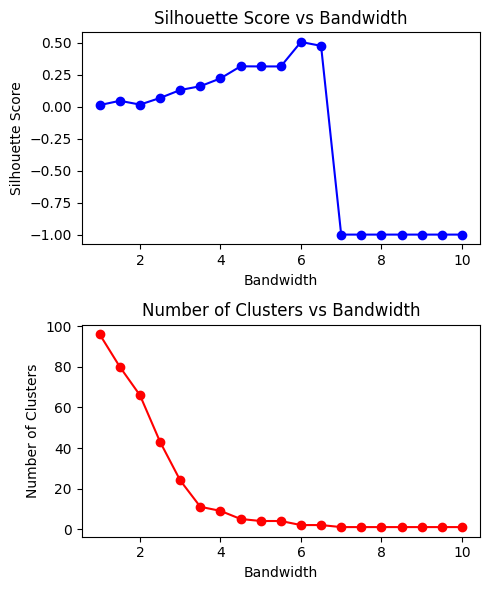

Best bandwidth: 6.0

Final clustering results:
Number of clusters: 2
Silhouette Score: 0.5044

Cluster sizes:
Cluster
0    96
1     3
Name: count, dtype: int64


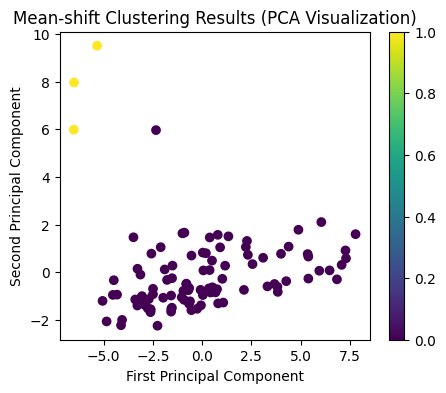


Feature Importances:
          Feature  Importance
15          A_std    0.577550
10          M_std    0.562838
12          M_max    0.559638
17          A_max    0.515822
18  20th_quantile    0.371480
19  25th_quantile    0.367790
16          A_min    0.366094
11          M_min    0.358638
4          Height    0.347297
7             BSA    0.344046
21  75th_quantile    0.341500
14       A_median    0.339352
8          M_mean    0.337254
20  50th_quantile    0.337152
9        M_median    0.334052
5          Weight    0.311344
13         A_mean    0.296859
2           Smoke    0.235775
3    Smoke_amount    0.196920
0             Age    0.127816
6             BMI    0.100678
1             Sex    0.066448


In [13]:
import pandas as pd
import numpy as np
from sklearn.cluster import MeanShift
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Load the data
data = pd.read_csv("data/translated.csv")

# Select the relevant columns
columns_to_use = [
    "Age",
    "Sex",
    "Smoke",
    "Smoke_amount",
    "Height",
    "Weight",
    "BMI",
    "BSA",
    "M_mean",
    "M_median",
    "M_std",
    "M_min",
    "M_max",
    "A_mean",
    "A_median",
    "A_std",
    "A_min",
    "A_max",
    "20th_quantile",
    "25th_quantile",
    "50th_quantile",
    "75th_quantile",
]

# Prepare the data
X = data[columns_to_use].copy()

# Convert categorical variables to numeric
X["Sex"] = X["Sex"].map({"M": 0, "F": 1})
X["Smoke"] = X["Smoke"].map({"NS": 0, "ES": 1, "SM": 2})

# Handle missing values
X = X.fillna(X.mean())

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Function to perform Mean-shift clustering and calculate silhouette score
def perform_clustering(bandwidth, min_cluster_size):
    ms = MeanShift(bandwidth=bandwidth, min_bin_freq=min_cluster_size, n_jobs=-1)
    labels = ms.fit_predict(X_scaled)
    n_clusters = len(np.unique(labels))
    if n_clusters > 1:
        score = silhouette_score(X_scaled, labels)
    else:
        score = -1  # Invalid clustering result
    return ms, labels, score, n_clusters


# Try different bandwidth values
bandwidths = np.arange(1.0, 10.1, 0.5)
min_cluster_size = 5  # Minimum number of samples in each cluster
scores = []
n_clusters = []

for bandwidth in bandwidths:
    ms, labels, score, num_clusters = perform_clustering(bandwidth, min_cluster_size)
    scores.append(score)
    n_clusters.append(num_clusters)
    print(
        f"Bandwidth: {bandwidth:.1f}, Clusters: {num_clusters}, Silhouette Score: {score:.4f}"
    )

# Plot the results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 6))

ax1.plot(bandwidths, scores, "bo-")
ax1.set_xlabel("Bandwidth")
ax1.set_ylabel("Silhouette Score")
ax1.set_title("Silhouette Score vs Bandwidth")

ax2.plot(bandwidths, n_clusters, "ro-")
ax2.set_xlabel("Bandwidth")
ax2.set_ylabel("Number of Clusters")
ax2.set_title("Number of Clusters vs Bandwidth")

plt.tight_layout()
plt.show()

# Choose the best bandwidth based on the highest silhouette score
valid_scores = [s for s in scores if s > 0]
if valid_scores:
    best_bandwidth = bandwidths[scores.index(max(valid_scores))]
    print(f"Best bandwidth: {best_bandwidth:.1f}")

    # Perform final clustering with the best bandwidth
    best_ms, best_labels, best_score, best_n_clusters = perform_clustering(
        best_bandwidth, min_cluster_size
    )

    # Add cluster labels to the original dataframe
    data["Cluster"] = best_labels

    # Print summary of the clustering results
    print(f"\nFinal clustering results:")
    print(f"Number of clusters: {best_n_clusters}")
    print(f"Silhouette Score: {best_score:.4f}")
    print("\nCluster sizes:")
    print(data["Cluster"].value_counts().sort_index())

    # Visualize the clusters using PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    plt.figure(figsize=(5, 4))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=best_labels, cmap="viridis")
    plt.colorbar(scatter)
    plt.xlabel("First Principal Component")
    plt.ylabel("Second Principal Component")
    plt.title("Mean-shift Clustering Results (PCA Visualization)")
    plt.show()

    # Print feature importances
    feature_importance = pd.DataFrame(
        {
            "Feature": columns_to_use,
            "Importance": np.abs(pca.components_[0]) + np.abs(pca.components_[1]),
        }
    )
    feature_importance = feature_importance.sort_values("Importance", ascending=False)
    print("\nFeature Importances:")
    print(feature_importance)
else:
    print(
        "No valid clustering results found. Try adjusting the bandwidth range or minimum cluster size."
    )

In [ ]:
# Based on the output provided, I'll summarize the key findings and provide some insights:

# Clustering Results:

# The best bandwidth for Mean-shift clustering was found to be 6.0.
# This resulted in 2 clusters with a Silhouette Score of 0.5044.
# The cluster sizes are very imbalanced: Cluster 0 has 96 samples, while Cluster 1 has only 3 samples.


# Feature Importances:
# The top 5 most important features for distinguishing between clusters are:

# A_std (Afternoon standard deviation)
# M_std (Morning standard deviation)
# M_max (Morning maximum value)
# A_max (Afternoon maximum value)
# 20th_quantile

# Interestingly, the standard deviations and maximum values of both morning and afternoon measurements seem to be the most influential in determining the clusters. This suggests that the variability and extreme values of the measurements are more important for clustering than the average values.
# Least Important Features:

# Sex
# BMI
# Age

# These features had the least impact on the clustering results.
# Interpretation:

# The clustering seems to be primarily based on the variability of measurements (standard deviations) and extreme values (maximums).
# The fact that we have two very imbalanced clusters (96 vs 3 samples) suggests that there might be a small group of outliers or patients with significantly different characteristics.
# The high importance of std and max values might indicate that the clustering is separating patients with more stable measurements from those with more variable or extreme measurements.


# Limitations and Considerations:

# The large imbalance between clusters suggests that this might not be the most informative clustering for all purposes. It essentially separates a small group from the majority.
# The silhouette score of 0.5044 indicates a moderate structure in the data. While it's not a poor clustering, there might be room for improvement.
# Given the small size of one cluster, it would be worth investigating these three samples to understand what makes them so different from the rest.


# Next Steps:

# Examine the characteristics of the 3 samples in Cluster 1 to understand what sets them apart.
# Consider trying other clustering algorithms (e.g., K-means, DBSCAN) to see if they provide more balanced or interpretable results.
# Look into the correlation between the top important features to see if there's any redundancy.
# Consider feature engineering or selection to focus on the most relevant variables for your specific analysis goals.